# Customer Segmentation using Gaussian Mixture Models and KMeans

In this notebook, we'll perform customer segmentation using both Gaussian Mixture Models (GMM) and KMeans clustering algorithms, then compare the results.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv('marketing_campaign.csv') 

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                    Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                    --------------  ----- 
 0   ID	Year_Birth	Education	Marital_Status	Income	Kidhome	Teenhome	Dt_Customer	Recency	MntWines	MntFruits	MntMeat

In [76]:
df.head()

,ID\tYear_Birth\tEducation\tMarital_Status\tIncome\tKidhome\tTeenhome\tDt_Customer\tRecency\tMntWines\tMntFruits\tMntMeatProducts\tMntFishProducts\tMntSweetProducts\tMntGoldProds\tNumDealsPurchases\tNumWebPurchases\tNumCatalogPurchases\tNumStorePurchases\tNumWebVisitsMonth\tAcceptedCmp3\tAcceptedCmp4\tAcceptedCmp5\tAcceptedCmp1\tAcceptedCmp2\tComplain\tZ_CostContact\tZ_Revenue\tResponse
0,5524\t1957\tGraduation\tSingle\t58138\t0\t0\t0...
1,2174\t1954\tGraduation\tSingle\t46344\t1\t1\t0...
2,4141\t1965\tGraduation\tTogether\t71613\t0\t0\...
3,6182\t1984\tGraduation\tTogether\t26646\t1\t0\...
4,5324\t1981\tPhD\tMarried\t58293\t1\t0\t19-01-2...


In [77]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [78]:
print("Data shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

Data shape: (2240, 29)

Missing values:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Data types:
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  

## 1. Data Preprocessing

Let's handle missing values and convert all columns into numeric form as required.

In [79]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

if 'Dt_Customer' in df.columns:
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
    df['Customer_Tenure'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days
    df.drop('Dt_Customer', axis=1, inplace=True)

if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

In [80]:
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", list(categorical_cols))

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nShape after encoding:", df_encoded.shape)
print("\nEncoded columns:", list(df_encoded.columns)[:10], "...")

Categorical columns: ['Education', 'Marital_Status']

Shape after encoding: (2240, 37)

Encoded columns: ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts'] ...


In [81]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

print("Shape after scaling:", df_scaled.shape)
df_scaled.head()

Shape after scaling: (2240, 37)


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,-0.985345,0.235696,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,...,0.993769,-0.444816,-0.526385,-0.036621,-0.339909,-0.792406,1.914854,-0.591099,-0.188676,-0.029894
1,-1.235733,-0.235454,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,...,0.993769,-0.444816,-0.526385,-0.036621,-0.339909,-0.792406,1.914854,-0.591099,-0.188676,-0.029894
2,-0.317643,0.773999,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,...,0.993769,-0.444816,-0.526385,-0.036621,-0.339909,-0.792406,-0.522233,1.691765,-0.188676,-0.029894
3,1.268149,-1.022355,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,...,0.993769,-0.444816,-0.526385,-0.036621,-0.339909,-0.792406,-0.522233,1.691765,-0.188676,-0.029894
4,1.017761,0.241888,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,...,-1.006270,-0.444816,1.899751,-0.036621,-0.339909,1.261980,-0.522233,-0.591099,-0.188676,-0.029894


## 2. Finding Optimal Number of Clusters

We'll use the Silhouette score to determine the optimal number of clusters for both GMM and KMeans.

In [82]:
def calculate_silhouette_scores(data, model_class, param_name, range_n_clusters, **kwargs):
    silhouette_scores = []
    
    for n_clusters in range_n_clusters:
        kwargs[param_name] = n_clusters
        model = model_class(**kwargs)
        
        cluster_labels = model.fit_predict(data)
        
        if len(np.unique(cluster_labels)) > 1:
            score = silhouette_score(data, cluster_labels)
        else:
            score = -1
        
        silhouette_scores.append(score)
        print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
    return silhouette_scores

In [83]:
range_n_clusters = range(2, 11)
print("Finding optimal number of clusters for KMeans:")
kmeans_silhouette_scores = calculate_silhouette_scores(
    df_scaled, 
    KMeans, 
    'n_clusters', 
    range_n_clusters,
    random_state=42,
    n_init=10,
    max_iter=300
)

Finding optimal number of clusters for KMeans:
Clusters: 2, Silhouette Score: 0.1775
Clusters: 3, Silhouette Score: 0.1163
Clusters: 3, Silhouette Score: 0.1163
Clusters: 4, Silhouette Score: 0.1165
Clusters: 4, Silhouette Score: 0.1165
Clusters: 5, Silhouette Score: 0.1318
Clusters: 5, Silhouette Score: 0.1318
Clusters: 6, Silhouette Score: 0.0791
Clusters: 6, Silhouette Score: 0.0791
Clusters: 7, Silhouette Score: 0.0754
Clusters: 8, Silhouette Score: 0.1006
Clusters: 7, Silhouette Score: 0.0754
Clusters: 8, Silhouette Score: 0.1006
Clusters: 9, Silhouette Score: 0.0782
Clusters: 10, Silhouette Score: 0.0739
Clusters: 9, Silhouette Score: 0.0782
Clusters: 10, Silhouette Score: 0.0739


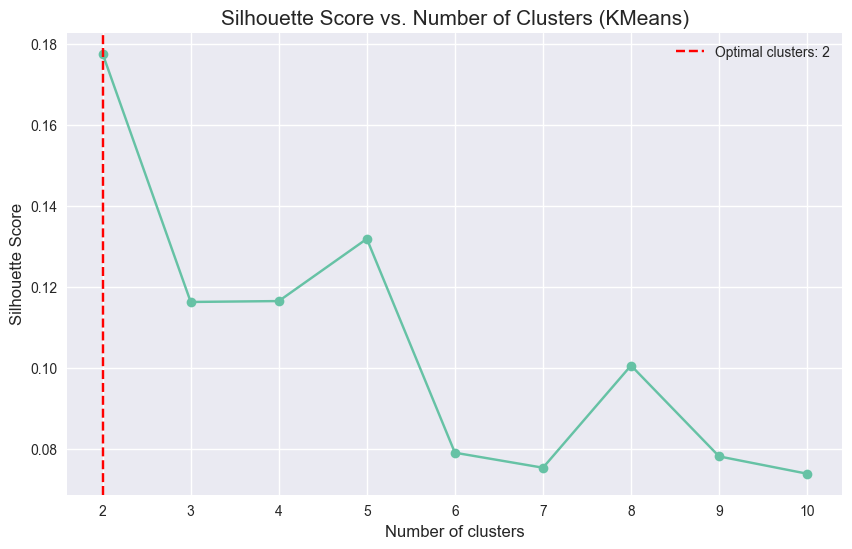

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, kmeans_silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (KMeans)', fontsize=15)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.xticks(range_n_clusters)
best_kmeans_clusters = range_n_clusters[kmeans_silhouette_scores.index(max(kmeans_silhouette_scores))]
plt.axvline(x=best_kmeans_clusters, color='r', linestyle='--', label=f'Optimal clusters: {best_kmeans_clusters}')
plt.legend()
plt.show()

In [85]:
print("Finding optimal number of clusters for GMM:")
gmm_silhouette_scores = calculate_silhouette_scores(
    df_scaled, 
    GaussianMixture, 
    'n_components', 
    range_n_clusters,
    random_state=42,
    covariance_type='full',
    max_iter=100
)

Finding optimal number of clusters for GMM:
Clusters: 2, Silhouette Score: 0.1648
Clusters: 3, Silhouette Score: 0.2336
Clusters: 4, Silhouette Score: 0.1555
Clusters: 3, Silhouette Score: 0.2336
Clusters: 4, Silhouette Score: 0.1555
Clusters: 5, Silhouette Score: 0.1440
Clusters: 6, Silhouette Score: 0.0654
Clusters: 5, Silhouette Score: 0.1440
Clusters: 6, Silhouette Score: 0.0654
Clusters: 7, Silhouette Score: 0.0705
Clusters: 8, Silhouette Score: 0.0495
Clusters: 7, Silhouette Score: 0.0705
Clusters: 8, Silhouette Score: 0.0495
Clusters: 9, Silhouette Score: 0.0516
Clusters: 9, Silhouette Score: 0.0516
Clusters: 10, Silhouette Score: 0.0559
Clusters: 10, Silhouette Score: 0.0559


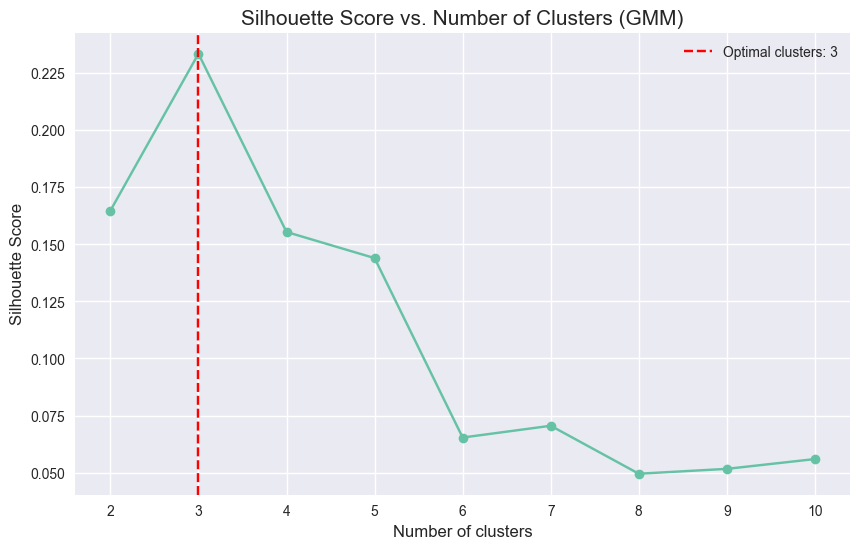

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, gmm_silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (GMM)', fontsize=15)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.xticks(range_n_clusters)
best_gmm_clusters = range_n_clusters[gmm_silhouette_scores.index(max(gmm_silhouette_scores))]
plt.axvline(x=best_gmm_clusters, color='r', linestyle='--', label=f'Optimal clusters: {best_gmm_clusters}')
plt.legend()
plt.show()

## 3. Clustering with Optimal Parameters

Now that we have determined the optimal number of clusters for both algorithms, let's apply them to our data.

In [87]:
kmeans = KMeans(n_clusters=best_kmeans_clusters, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

gmm = GaussianMixture(n_components=best_gmm_clusters, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_scaled)

print("KMeans cluster distribution:")
print(df['KMeans_Cluster'].value_counts())

print("\nGMM cluster distribution:")
print(df['GMM_Cluster'].value_counts())

KMeans cluster distribution:
KMeans_Cluster
0    1353
1     887
Name: count, dtype: int64

GMM cluster distribution:
GMM_Cluster
2    1864
1     279
0      97
Name: count, dtype: int64


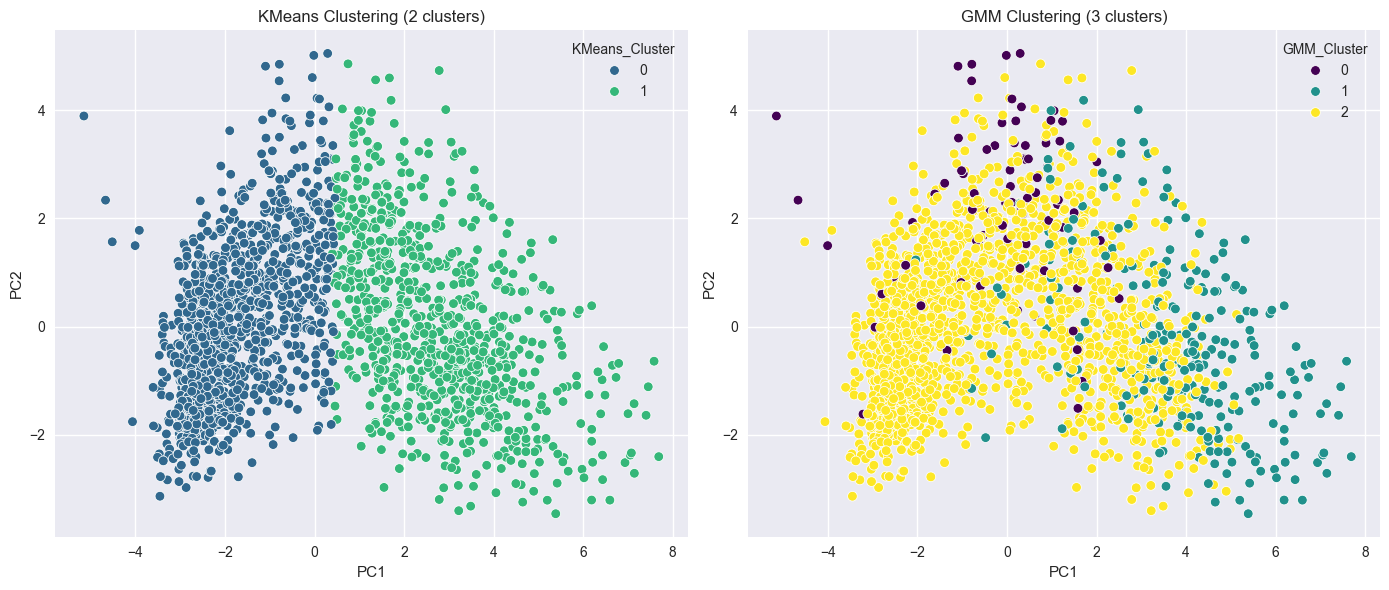

In [88]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plot_df = pd.DataFrame({
    'PC1': df_pca[:, 0],
    'PC2': df_pca[:, 1],
    'KMeans_Cluster': df['KMeans_Cluster'],
    'GMM_Cluster': df['GMM_Cluster']
})

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis')
plt.title(f'KMeans Clustering ({best_kmeans_clusters} clusters)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='GMM_Cluster', palette='viridis')
plt.title(f'GMM Clustering ({best_gmm_clusters} clusters)')

plt.tight_layout()
plt.show()

## 4. Extract Centroids and Means

Let's extract the centroids from KMeans and means from GMM.

In [89]:
kmeans_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
kmeans_centroids_df = pd.DataFrame(kmeans_centroids, columns=df_encoded.columns)
print("KMeans Centroids:")
kmeans_centroids_df.head()

KMeans Centroids:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,1969.930525,39204.325203,0.692535,0.558758,48.827051,105.441242,6.631190,37.811530,9.792313,6.830007,...,0.482631,0.176644,0.206208,2.217295e-03,0.096822,0.397635,0.214339,0.260163,0.027347,1.478197e-03
1,1967.090192,72119.067644,0.065389,0.426156,49.540023,606.712514,56.307779,363.933484,79.828636,57.925592,...,0.534386,0.147689,0.233371,4.336809e-19,0.113867,0.367531,0.214205,0.257046,0.045096,-1.409463e-18


In [90]:
gmm_means = scaler.inverse_transform(gmm.means_)
gmm_means_df = pd.DataFrame(gmm_means, columns=df_encoded.columns)
print("GMM Means:")
gmm_means_df.head()

GMM Means:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,1963.927563,52040.641361,0.391773,0.804113,52.318446,422.517436,11.544431,71.201678,11.256078,6.845297,...,0.474252,0.185524,0.278365,3.092946e-02,0.134028,0.360844,0.154595,0.257745,0.041239,2.061964e-02
1,1968.240159,81142.042894,0.071683,0.236573,48.369645,757.247680,50.297465,440.937465,78.164227,59.604793,...,0.519704,0.157721,0.229387,-4.336809e-19,0.075267,0.412179,0.211484,0.250892,0.043010,-8.673617e-19
2,1969.144313,47921.858637,0.502682,0.531116,49.053112,229.913090,23.478541,130.921674,32.809549,23.244099,...,0.502146,0.165236,0.211910,1.084202e-18,0.106223,0.383047,0.217811,0.260193,0.032725,1.843144e-18


## 5. Create Cluster Profile Tables

Now, let's create tables showing the means of important features for each cluster.

In [91]:
important_features = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
                      'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                      'NumWebVisitsMonth']

available_features = [f for f in important_features if f in df_encoded.columns]

kmeans_profiles = pd.DataFrame(index=range(best_kmeans_clusters), columns=available_features)
for i in range(best_kmeans_clusters):
    for feature in available_features:
        kmeans_profiles.loc[i, feature] = kmeans_centroids_df.loc[i, feature]

kmeans_profiles.index.name = 'Cluster'
kmeans_profiles = kmeans_profiles.round(2)

print("KMeans Cluster Profiles:")
kmeans_profiles

KMeans Cluster Profiles:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Cluster,,,,,,,,,,,,,,,,
0,1969.930525,39204.325203,0.692535,0.558758,48.827051,105.441242,6.63119,37.81153,9.792313,6.830007,22.747967,2.541759,2.968219,0.898744,3.97561,6.390983
1,1967.090192,72119.067644,0.065389,0.426156,49.540023,606.712514,56.307779,363.933484,79.828636,57.925592,76.472379,1.994363,5.78805,5.351747,8.558061,3.677565


In [92]:
gmm_profiles = pd.DataFrame(index=range(best_gmm_clusters), columns=available_features)
for i in range(best_gmm_clusters):
    for feature in available_features:
        gmm_profiles.loc[i, feature] = gmm_means_df.loc[i, feature]

gmm_profiles.index.name = 'Cluster'
gmm_profiles = gmm_profiles.round(2)

print("GMM Cluster Profiles:")
gmm_profiles

GMM Cluster Profiles:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Cluster,,,,,,,,,,,,,,,,
0,1963.927563,52040.641361,0.391773,0.804113,52.318446,422.517436,11.544431,71.201678,11.256078,6.845297,28.593768,3.79396,5.113408,2.102888,6.535848,6.660037
1,1968.240159,81142.042894,0.071683,0.236573,48.369645,757.24768,50.297465,440.937465,78.164227,59.604793,75.014939,1.462357,5.652318,5.853049,7.838767,3.268794
2,1969.144313,47921.858637,0.502682,0.531116,49.053112,229.91309,23.478541,130.921674,32.809549,23.244099,40.185622,2.377682,3.796674,2.213519,5.444742,5.553112


## 6. Cluster Interpretation and Customer Profiling

Now, let's interpret the clusters and create customer profiles.

In [93]:
numeric_columns = df.select_dtypes(include=['number']).columns
kmeans_cluster_stats = df.groupby('KMeans_Cluster')[numeric_columns].mean()
print("KMeans Cluster Statistics:")
kmeans_cluster_stats

KMeans Cluster Statistics:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_Tenure,KMeans_Cluster,GMM_Cluster
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1969.930525,39204.325203,0.692535,0.558758,48.827051,105.441242,6.631190,37.811530,9.792313,6.830007,...,0.000000,0.005174,0.001478,0.010347,3.0,11.0,0.093865,338.417591,0.0,1.888396
1,1967.090192,72119.067644,0.065389,0.426156,49.540023,606.712514,56.307779,363.933484,79.828636,57.925592,...,0.183766,0.154453,0.031567,0.007892,3.0,11.0,0.233371,376.713641,1.0,1.636979


In [94]:
numeric_columns = df.select_dtypes(include=['number']).columns
gmm_cluster_stats = df.groupby('GMM_Cluster')[numeric_columns].mean()
print("GMM Cluster Statistics:")
gmm_cluster_stats

GMM Cluster Statistics:


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_Tenure,KMeans_Cluster,GMM_Cluster
GMM_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1963.927835,52041.206186,0.391753,0.804124,52.319588,422.525773,11.546392,71.206186,11.257732,6.845361,...,0.000000,0.020619,0.000000,0.206186,3.0,11.0,0.144330,358.752577,0.278351,0.0
1,1968.240143,81142.378136,0.071685,0.236559,48.369176,757.250896,50.297491,440.942652,78.164875,59.605735,...,0.584229,0.508961,0.107527,0.003584,3.0,11.0,0.440860,342.634409,0.960573,1.0
2,1969.144313,47921.858637,0.502682,0.531116,49.053112,229.913090,23.478541,130.921674,32.809549,23.244099,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.105687,354.951717,0.317597,2.0


## Customer Profiles Based on KMeans Clusters

Let's create detailed customer profiles for each cluster based on the KMeans results. For each cluster, we'll describe a fictional customer that represents the characteristics of that cluster.

In [95]:
def create_customer_profiles(cluster_profiles, algorithm_name):
    print(f"\n{algorithm_name} Customer Profiles:\n" + "-"*50)
    
    for cluster in cluster_profiles.index:
        profile = cluster_profiles.loc[cluster]
        
        birth_year = int(profile['Year_Birth']) if 'Year_Birth' in profile else 1970
        age = 2023 - birth_year
        
        income = profile['Income'] if 'Income' in profile else 'N/A'
        kids = profile['Kidhome'] if 'Kidhome' in profile else 0
        teens = profile['Teenhome'] if 'Teenhome' in profile else 0
        recency = profile['Recency'] if 'Recency' in profile else 0
        
        wine_spending = profile['MntWines'] if 'MntWines' in profile else 0
        meat_spending = profile['MntMeatProducts'] if 'MntMeatProducts' in profile else 0
        fish_spending = profile['MntFishProducts'] if 'MntFishProducts' in profile else 0
        sweet_spending = profile['MntSweetProducts'] if 'MntSweetProducts' in profile else 0
        fruit_spending = profile['MntFruits'] if 'MntFruits' in profile else 0
        gold_spending = profile['MntGoldProds'] if 'MntGoldProds' in profile else 0
        
        deals = profile['NumDealsPurchases'] if 'NumDealsPurchases' in profile else 0
        web_purchases = profile['NumWebPurchases'] if 'NumWebPurchases' in profile else 0
        catalog_purchases = profile['NumCatalogPurchases'] if 'NumCatalogPurchases' in profile else 0
        store_purchases = profile['NumStorePurchases'] if 'NumStorePurchases' in profile else 0
        web_visits = profile['NumWebVisitsMonth'] if 'NumWebVisitsMonth' in profile else 0
        
        total_spending = wine_spending + meat_spending + fish_spending + sweet_spending + fruit_spending + gold_spending
        
        if total_spending > 1000:
            spending_category = "High Spender"
        elif total_spending > 500:
            spending_category = "Medium Spender"
        else:
            spending_category = "Budget Conscious"
        
        channels = {'Web': web_purchases, 'Catalog': catalog_purchases, 'Store': store_purchases}
        preferred_channel = max(channels, key=channels.get)
        
        if kids > 0 and teens > 0:
            household = f"Family with {int(kids)} young child(ren) and {int(teens)} teenager(s)"
        elif kids > 0:
            household = f"Family with {int(kids)} young child(ren)"
        elif teens > 0:
            household = f"Family with {int(teens)} teenager(s)"
        else:
            household = "No children at home"
            
        names = ["Alex", "Jamie", "Morgan", "Casey", "Taylor", "Jordan", "Riley", "Quinn", "Avery", "Dakota"]
        customer_name = names[cluster % len(names)]
        
        print(f"\nCluster {cluster}: {spending_category}")
        print(f"Meet {customer_name}, a {age} year old customer with an annual income of ${income:.0f}.")
        print(f"Household: {household}")
        print(f"Shopping Behavior: Prefers {preferred_channel} shopping. Makes about {int(store_purchases)} store visits, "
              f"{int(web_purchases)} web purchases, and {int(catalog_purchases)} catalog purchases.")
        print(f"Spending Habits: ${total_spending:.0f} total. Wine: ${wine_spending:.0f}, Meat: ${meat_spending:.0f}, "
              f"Fish: ${fish_spending:.0f}, Sweets: ${sweet_spending:.0f}, Fruits: ${fruit_spending:.0f}, Gold: ${gold_spending:.0f}")
        print(f"Deal Sensitivity: Purchased {int(deals)} deals")
        print(f"Engagement: Visits the website {int(web_visits)} times per month and last purchased {int(recency)} days ago.")

In [96]:
create_customer_profiles(kmeans_profiles, "KMeans")


KMeans Customer Profiles:
--------------------------------------------------

Cluster 0: Budget Conscious
Meet Alex, a 54 year old customer with an annual income of $39204.
Household: Family with 0 young child(ren) and 0 teenager(s)
Shopping Behavior: Prefers Store shopping. Makes about 3 store visits, 2 web purchases, and 0 catalog purchases.
Spending Habits: $189 total. Wine: $105, Meat: $38, Fish: $10, Sweets: $7, Fruits: $7, Gold: $23
Deal Sensitivity: Purchased 2 deals
Engagement: Visits the website 6 times per month and last purchased 48 days ago.

Cluster 1: High Spender
Meet Jamie, a 56 year old customer with an annual income of $72119.
Household: Family with 0 young child(ren) and 0 teenager(s)
Shopping Behavior: Prefers Store shopping. Makes about 8 store visits, 5 web purchases, and 5 catalog purchases.
Spending Habits: $1241 total. Wine: $607, Meat: $364, Fish: $80, Sweets: $58, Fruits: $56, Gold: $76
Deal Sensitivity: Purchased 1 deals
Engagement: Visits the website 3 tim

In [97]:
create_customer_profiles(gmm_profiles, "GMM")


GMM Customer Profiles:
--------------------------------------------------

Cluster 0: Medium Spender
Meet Alex, a 60 year old customer with an annual income of $52041.
Household: Family with 0 young child(ren) and 0 teenager(s)
Shopping Behavior: Prefers Store shopping. Makes about 6 store visits, 5 web purchases, and 2 catalog purchases.
Spending Habits: $552 total. Wine: $423, Meat: $71, Fish: $11, Sweets: $7, Fruits: $12, Gold: $29
Deal Sensitivity: Purchased 3 deals
Engagement: Visits the website 6 times per month and last purchased 52 days ago.

Cluster 1: High Spender
Meet Jamie, a 55 year old customer with an annual income of $81142.
Household: Family with 0 young child(ren) and 0 teenager(s)
Shopping Behavior: Prefers Store shopping. Makes about 7 store visits, 5 web purchases, and 5 catalog purchases.
Spending Habits: $1461 total. Wine: $757, Meat: $441, Fish: $78, Sweets: $60, Fruits: $50, Gold: $75
Deal Sensitivity: Purchased 1 deals
Engagement: Visits the website 3 times p